# Anomaly Detection mit Python
### Technik-Training vom 26. Januar 2022

##### Notebook-Struktur:
1. Library Import, set the stage
2. Connect Data
3. Erster Überblick und Datentypen 
4. Exploratory Data Analysis (kurz)
5. Error Handling und Outlier 
6. Feature Preprocessing und Engineering 
7. Feature Selection 
8. Modeling 
9. Evaluation
10. Ergebnisse zurückschreiben

## 1. Importieren der Python libraries
- Python und Data Science lebt von den sich ständig weiterentwickelnen Libraries 
- müssen im Environment installiert werden
- wenn keine weiteren Environments eingerichtet sind ist das default Environment "base" 

In [127]:
#ein must-have: Pandas und Numpy
import pandas as pd
import numpy as np

#pyodbc als ein package zur Verbindung mit der DB und SQL-Abfragen 
import pyodbc
 
#Seaborn und matplotlib als bekannteste Libraries zur Visualisierung
import seaborn as sns
import matplotlib as plt

#Sklearn oder sci-kit learn ist eines der größten Libraries rund um Machine Learning
from sklearn.ensemble import IsolationForest

#Darstellung: zeige alle Zeilen und Spalten
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2. Connect Data 
Verbindung mit SQL Server herstellen

In [128]:
#passenden Treiber auswählen, Server und DB angeben
cnxn_str = ("Driver={SQL Server Native Client 11.0};"
            "Server=LF86428159;"
            "Database=Test_DB_LD;"
            "Trusted_Connection=yes;")

cnxn = pyodbc.connect(cnxn_str)

SQL-Query

In [129]:
#initialize cursor
cursor = cnxn.cursor()

#Select-Statement
query="SELECT\
                t.[T_ID],p.[Pers_ID],p.[Geschlecht],p.[Alter],p.[Gemeinde],t.[Produktkonto],t.[Kosten]\
        FROM\
                 iForest.Dim_Person p\
        INNER JOIN\
                iForest.Fakt_Produkt_Buchungen t\
        ON p.Pers_ID=t.Pers_ID"
#cursor.execute(query)

#Pandas hat eine in-build function zum Ausführen der Query. Parameter: Verbindung und SQL-Statement
df = pd.read_sql(query, cnxn)


## 3. Erster Überblick und Datentypen

In [130]:
#Erstmal die Daten angucken: die head() function
df.head(10)

,T_ID,Pers_ID,Geschlecht,Alter,Gemeinde,Produktkonto,Kosten
0,1,1,w,2,Gemeinde_1,Sozialgeld,300.19
1,2,2,d,18,Gemeinde_1,Sozialgeld,327.21
2,3,3,m,36,Gemeinde_1,Sozialgeld,330.15
3,4,4,d,41,Gemeinde_2,Sozialgeld,333.12
4,5,5,w,52,Gemeinde_2,Sozialgeld,336.12
5,6,6,m,63,Gemeinde_2,Sozialgeld,339.15
6,7,7,w,3,Gemeinde_3,Sozialgeld,3339.15
7,8,8,m,86,Gemeinde_3,Sozialgeld,345.28
8,9,9,w,97,Gemeinde_4,Sozialgeld,348.39
9,10,10,m,101,Gemeinde_3,Sozialgeld,351.52


In [131]:
#info() gibt Informationen bezüglich der Datentypen und ob NULL-values vorhanden sind
df.info()

#Alternative: 
#df.dtypes
#df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   T_ID          100 non-null    int64 
 1   Pers_ID       100 non-null    int64 
 2   Geschlecht    100 non-null    object
 3   Alter         100 non-null    int64 
 4   Gemeinde      100 non-null    object
 5   Produktkonto  100 non-null    object
 6   Kosten        100 non-null    object
dtypes: int64(3), object(4)
memory usage: 5.6+ KB


##### Kosten sind als object/category (string) formatiert. Änderung in einen float Datentyp

In [132]:
df['Kosten'] = df['Kosten'].astype('float')

## 4. Exploratory Data Analysis (kurz!)
- eine EDA ist ein sehr wichtiges Werkzeug um die Daten kennenzulernen 
- Beurteilung der Datenqualität
- Grundlage für späteres Feature Engineering, Selection und Modeling
- Statistiken, Verteilungen, Korrelationen, Outlier und Korrelationen
- sogar Clustering kann (und sollte) als Teil des EDA genutzt werden

Check Statistiken und Korrelationen

In [133]:
#describe ist eine wunderbare Methode die Daten auf einen Blick einzuschätzen
#include all schließt auch alle nicht nummerischen Features mit ein 
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
T_ID,100.0,NaN,NaN,NaN,50.5,29.011492,1.0,25.75,50.5,75.25,100.0
Pers_ID,100.0,NaN,NaN,NaN,5.51,2.904177,1.0,3.0,5.5,8.0,11.0
Geschlecht,100,3,w,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alter,100.0,NaN,NaN,NaN,50.19,35.4944,2.0,18.0,46.5,86.0,130.0
Gemeinde,100,4,Gemeinde_3,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Produktkonto,100,3,Klassenfahrten,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kosten,100.0,NaN,NaN,NaN,453.2256,542.31592,30.94,112.245,365.99,652.675,4005.71


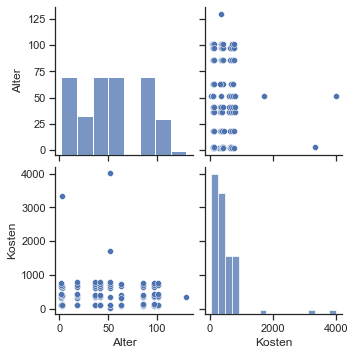

In [134]:
#Check Korrelationen und Distributionen mit Seaborn
sns.set_theme(style="ticks")
sns.pairplot(df[["Alter","Kosten"]])

## 5. Error-Handling und Outlier

Der älteste Mensch, dessen Alter wissenschaftlich verifiziert wurde, ist die Französin Jeanne Calment, die im Alter von 122 Jahren und 164 Tagen starb. 

--> Einträge über 122 Jahren werden herausgefiltert 

In [135]:
df2=df[df.Alter<123]
print(df.shape)
print(df2.shape)
print("Es wurde " + str(df.shape[0]-df2.shape[0]) +" Eintrag entfernt" )

(100, 7)
(99, 7)
Es wurde 1 Eintrag entfernt


**Das Ziel ist es Anomalien zu erkennen. Anomalien sind seltene Daten Punkte, sogenannte Outlier. Genau diese wollen wir erkennen und entfernen keine Outlier**

## 6. Preprocessing und Feature Engineering

**Feature Engineering**

*Feature Engineering* ist die Methode neue Features zu entwickeln mit dem Ziel mehr Informationen aus dem Daten zu erlangen und die Dimensionen/Features zu reduzieren

Beispiele:
1. Anzahl Bestellungen pro Kunde * Bestellwert --> Costumer Lifetime Value
2. Geschlecht aus Text Spalte filtern und encoden: "Herr Max Mustermann" --> 1; "Frau Mara Musterfrau" --> 0

**Slogan 1**: Die besten Algorithmen helfen nicht wenn der Informationsgehalt im Dataset schlecht ist. 

**Slogan 2**: Zu viele (redundante) Features verderben den Brei ("Curse of Dimensionality")

**Slogan 3**: Hyperparameter Tuning oder Deep Learning Modelle können die Performance verbessern, aber: Feature Engineering gibt den meisten boost!

In [136]:
#Eine Kopie erstellen, da sonst Konflikte mit einem vorher manipulierten Dataframe entstehen können (Setting with copy warning)
df2=df2.copy()

#bisher stehen die Kosten isoliert. Eine Verbindung mit dem Produkt könnte sinnvoll sein
#In-line Slogan 4: Median ist der bessere mean! Bill Gates und so...
df2["median_kosten_produkt"]=df2.groupby("Produktkonto").Kosten.transform("median")

#Da die Größenordnung in den Produkten variiert, ist die Variation vom Produkt-Median sinnvoller 
df2["variation_median_kosten_produkt"]=df2.Kosten-df2.median_kosten_produkt

In [137]:
df2.head()

,T_ID,Pers_ID,Geschlecht,Alter,Gemeinde,Produktkonto,Kosten,median_kosten_produkt,variation_median_kosten_produkt
0,1,1,w,2,Gemeinde_1,Sozialgeld,300.19,379.34,-79.15
1,2,2,d,18,Gemeinde_1,Sozialgeld,327.21,379.34,-52.13
2,3,3,m,36,Gemeinde_1,Sozialgeld,330.15,379.34,-49.19
3,4,4,d,41,Gemeinde_2,Sozialgeld,333.12,379.34,-46.22
4,5,5,w,52,Gemeinde_2,Sozialgeld,336.12,379.34,-43.22


**Preprocessing**

*Preprocessing* heißt den Datensatz so aufzubereiten, dass Algorithmen damit "arbeiten" können und wir Erkenntnisgewinne erlangen.
Viele Algorithmen können kategorische Daten nicht verarbeiten, da sie Distanz basiert arbeiten. 

In [138]:
#One-hot encode (in Pandas: get_dummies) to encode the categorical variables
df_encoded=pd.get_dummies(data=df2, columns=['Geschlecht', 'Gemeinde','Produktkonto'],prefix=['Geschlecht', 'Gemeinde','Produktkonto'])

In [139]:
df_encoded.head()

,T_ID,Pers_ID,Alter,Kosten,median_kosten_produkt,variation_median_kosten_produkt,Geschlecht_d,Geschlecht_m,Geschlecht_w,Gemeinde_Gemeinde_1,Gemeinde_Gemeinde_2,Gemeinde_Gemeinde_3,Gemeinde_Gemeinde_4,Produktkonto_ALG_2,Produktkonto_Klassenfahrten,Produktkonto_Sozialgeld
0,1,1,2,300.19,379.34,-79.15,0,0,1,1,0,0,0,0,0,1
1,2,2,18,327.21,379.34,-52.13,1,0,0,1,0,0,0,0,0,1
2,3,3,36,330.15,379.34,-49.19,0,1,0,1,0,0,0,0,0,1
3,4,4,41,333.12,379.34,-46.22,1,0,0,0,1,0,0,0,0,1
4,5,5,52,336.12,379.34,-43.22,0,0,1,0,1,0,0,0,0,1


## 7. Feature Selection


Welche Features sollen für das Model ausgewählt werden?
Methoden:
- Business Use Case 
- Korrelationen 
- Feature Importance

**Check Korrelation**

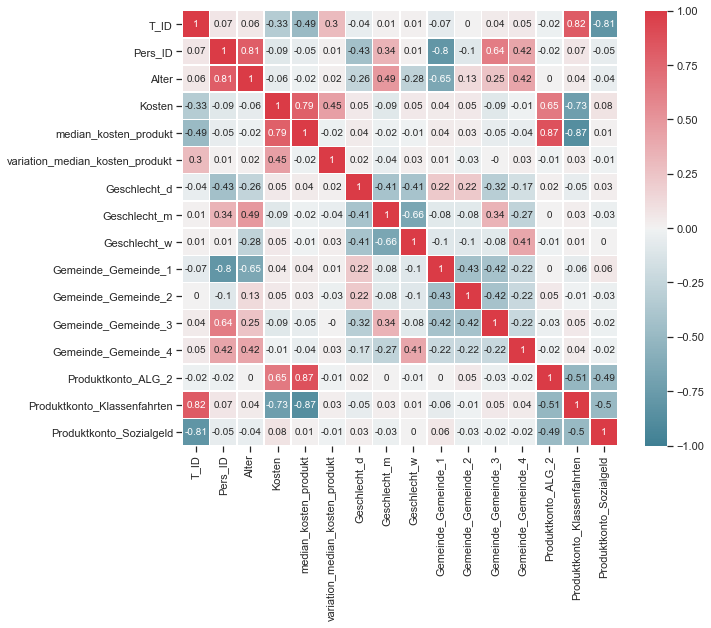

In [144]:
#Pandas function zur Ermittlung der Korrelationen 
correlation = df_encoded.corr(method="spearman").round(2)
plt.pyplot.figure(figsize=(10,8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, vmax=1,cmap=cmap, vmin=-1, center=0,square=True, linewidths=.5, annot=True, annot_kws={"size": 10})
sns.set(font_scale=1.5)

In [145]:
#median_kosten_produkt korreliert mit Kosten (schlüssig, da Feature hierauf basiert), ergo wird es gedropped
#Es wäre auch denkbar Kosten zu droppen, da es ähnliche Informationen enthält (machen wir trotzdem erstmal nicht)
df_model=df_encoded.drop(columns=["median_kosten_produkt"])

## 8. Modeling 

In [146]:
#Kopie des aktuellen DF
anomaly=df_model.copy()
#Contamination ist die Annahme, wie viel Prozent Anomalien enthalten sind. Hier: 10 Prozent
contamination=0.1
#Algorithmus Intanz initiieren; random_state setzen für gleiche Resultate
model=IsolationForest(contamination=contamination, random_state=0)
data = anomaly.drop(columns=['T_ID','Pers_ID'])

In [147]:
model.fit(data)
df_anomaly=df_model.copy()
df_anomaly['iScores']=model.decision_function(data)
df_anomaly['is_anomaly']=model.predict(data)
df_anomaly['is_anomaly']=df_anomaly['is_anomaly'].map({1: 0, -1: 1})

In [148]:
df_anomaly[df_anomaly.is_anomaly==1]

,T_ID,Pers_ID,Alter,Kosten,variation_median_kosten_produkt,Geschlecht_d,Geschlecht_m,Geschlecht_w,Gemeinde_Gemeinde_1,Gemeinde_Gemeinde_2,Gemeinde_Gemeinde_3,Gemeinde_Gemeinde_4,Produktkonto_ALG_2,Produktkonto_Klassenfahrten,Produktkonto_Sozialgeld,iScores,is_anomaly
6,7,7,3,3339.15,2959.81,0,0,1,0,0,1,0,0,0,1,-0.120499,1
25,26,5,52,4005.71,3626.37,0,0,1,0,1,0,0,0,0,1,-0.116098,1
36,37,6,63,317.13,-370.05,0,1,0,0,1,0,0,1,0,0,-0.034500,1
39,40,9,97,633.94,-53.24,0,0,1,0,0,0,1,1,0,0,-0.003608,1
40,41,10,101,63.65,-623.53,0,1,0,0,0,1,0,1,0,0,-0.085858,1
57,58,7,3,144.88,-542.30,0,0,1,0,0,1,0,1,0,0,-0.048382,1
59,60,9,97,758.35,71.17,0,0,1,0,0,0,1,1,0,0,-0.011090,1
62,63,2,18,779.01,91.83,1,0,0,1,0,0,0,1,0,0,-0.013655,1
64,65,4,41,793.10,105.92,1,0,0,0,1,0,0,1,0,0,-0.001891,1
95,96,5,52,1719.38,1613.83,0,0,1,0,1,0,0,0,1,0,-0.098220,1


## 8. Evaluation 

Die Evaluation ist eine Herausforderung und Bedarf Expertise! Prüfung, ob Labels und Scores okay sind. Ermittlung der Performance Metrics (Beispiele):
1. Accuracy
2. Recall
3. Precision
4. F1-Score

## 9. Rückschreiben in die Datenbank

In [110]:
# creating column list for insertion
cols = "`,`".join([str(i) for i in df_anomaly.columns.tolist()])

# Insert DataFrame records one by one.
for i,row in df_anomaly.iterrows():
    sql = "INSERT INTO `iForest.Fakt_iScores_Results` (`" +cols + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
    cursor.execute(sql, tuple(row))

    # the connection is not autocommitted by default, so we must commit to save our changes
    cnxn.commit()

ProgrammingError: ('The SQL contains 0 parameter markers, but 17 parameters were supplied', 'HY000')